In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HyperbolicMultinomialRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(HyperbolicMultinomialRegression, self).__init__()
        # Define weights without biases to avoid complications in hyperbolic space
        self.weight = nn.Parameter(torch.Tensor(num_classes, input_dim))
        nn.init.xavier_uniform_(self.weight)  # Initialize weights

    def lorentz_inner_product(self, x, v):
        # Compute the Lorentzian inner product
        return -x[:, 0] * v[:, 0] + torch.sum(x[:, 1:] * v[:, 1:], dim=1)

    def forward(self, x):
        # Embed input x into hyperbolic space
        x0 = torch.sqrt(1 + torch.sum(x**2, dim=1, keepdim=True))
        x_hyperbolic = torch.cat([x0, x], dim=1)  # Shape: (batch_size, input_dim + 1)

        # Construct hyperplane normal vectors
        w = self.weight  # Shape: (num_classes, input_dim)
        w0 = torch.sqrt(1 + torch.sum(w**2, dim=1, keepdim=True))  # Shape: (num_classes, 1)
        hyperplanes = torch.cat([w0, w], dim=1)  # Shape: (num_classes, input_dim + 1)

        # Compute Lorentz inner products between points and hyperplanes
        # Vectorize computation over batch and classes
        x_expanded = x_hyperbolic.unsqueeze(1)  # Shape: (batch_size, 1, input_dim + 1)
        hyperplanes_expanded = hyperplanes.unsqueeze(0)  # Shape: (1, num_classes, input_dim + 1)
        lorentz_products = -x_expanded[:, :, 0] * hyperplanes_expanded[:, :, 0] + \
                           torch.sum(x_expanded[:, :, 1:] * hyperplanes_expanded[:, :, 1:], dim=2)

        # Compute distances using the corrected formula
        distances = torch.acosh(-lorentz_products)  # Shape: (batch_size, num_classes)

        # Convert negative distances to logits
        logits = -distances
        return F.softmax(logits, dim=1)
    
class EuclideanMultinomialRegression(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(EuclideanMultinomialRegression, self).__init__()
        self.linear = nn.Linear(input_dim, num_classes)
    
    def forward(self, x):
        logits = self.linear(x)  # Shape: (batch_size, num_classes)
        return F.softmax(logits, dim=1)

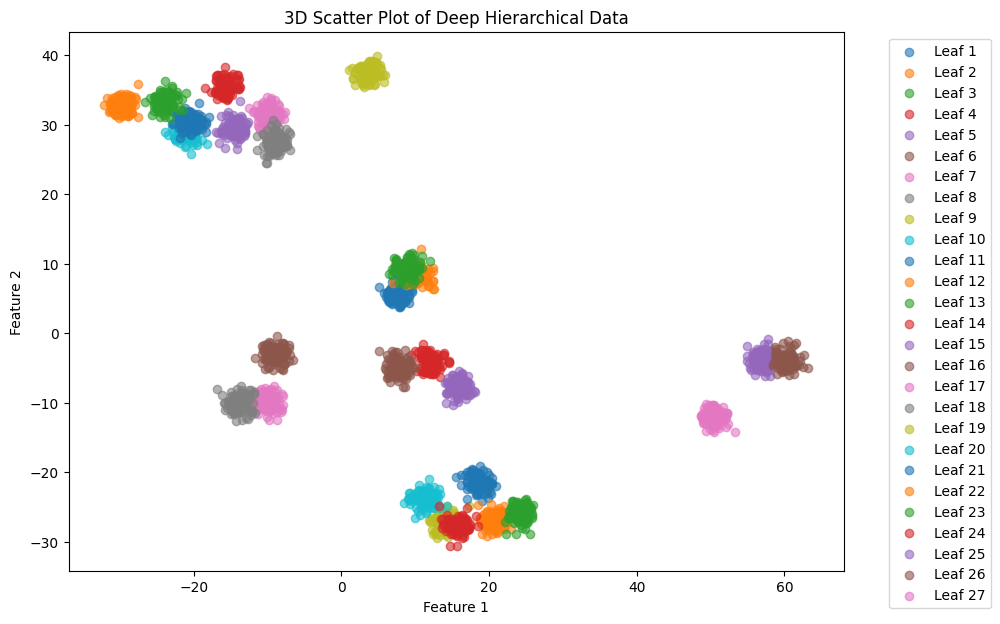

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def generate_deep_hierarchical_data(num_samples_per_leaf=100, input_dim=3, num_top_classes=3, num_mid_classes=2):
    np.random.seed(42)
    X = []
    y = []
    class_label = 0

    # Top level
    for i in range(num_top_classes):
        top_mean = np.random.randn(input_dim) * 10 * (i + 1)
        
        # Middle level
        for j in range(num_mid_classes):
            mid_mean = top_mean + np.random.randn(input_dim) * 5 * (j + 1)
            
            # Leaf level
            for k in range(num_mid_classes):
                leaf_mean = mid_mean + np.random.randn(input_dim) * 2 * (k + 1)
                cov = np.eye(input_dim)
                samples = np.random.multivariate_normal(leaf_mean, cov, num_samples_per_leaf)
                labels = np.full(num_samples_per_leaf, class_label)
                X.append(samples)
                y.append(labels)
                class_label += 1  # Unique label for each leaf

    X = np.vstack(X)
    y = np.concatenate(y)
    return X, y

# Generate the hierarchical data
input_dim = 2
num_top_classes = 3
num_mid_classes = 3

num_labels = num_mid_classes * num_top_classes * input_dim

X, y = generate_deep_hierarchical_data(num_samples_per_leaf=100, 
                                       input_dim=input_dim, 
                                       num_top_classes=num_top_classes, 
                                       num_mid_classes=num_mid_classes)

# Visualize with a 3D Scatter Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

for label in np.unique(y):
    class_points = X[y == label]
    ax.scatter(class_points[:, 0], class_points[:, 1], label=f'Leaf {label+1}', alpha=0.6)
ax.set_title("3D Scatter Plot of Deep Hierarchical Data")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [4]:
from sklearn.model_selection import train_test_split
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Convert data to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).long()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).long()

In [5]:
learning_rate = 0.01
num_epochs = 100
batch_size = 64

from torch.utils.data import TensorDataset, DataLoader

device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

from tqdm import tqdm

def train_model(model, device, X_train, y_train):
    model = model.to(device)
    X_train, y_train = X_train.to(device), y_train.to(device)
    # Create DataLoader
    dataset = TensorDataset(X_train, y_train)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        epoch_loss = 0
        for batch_X, batch_y in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            probs = model(batch_X)
            loss = criterion(probs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        if epoch % 10 == 0:
            print(f"Loss: {epoch_loss/len(dataloader):.2f}")
    print("Training finished")
    return model

In [6]:
# Instantiate models
euclidean_model = EuclideanMultinomialRegression(input_dim, num_labels)
hyperbolic_model = HyperbolicMultinomialRegression(input_dim, num_labels)

# Train Euclidean model
euclidean_model = train_model(euclidean_model, device, X_train_tensor, y_train_tensor)
hyperbolic_model = train_model(hyperbolic_model, device, X_train_tensor, y_train_tensor)

Epoch 1/100:   0%|          | 0/34 [00:00<?, ?it/s]../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [14,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [16,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [18,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [19,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [28,0,0] Assertion `t >= 0 && t < n_classes` failed.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
